# Imports

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ReLU
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Data preparation

In [2]:
(ds,), info = tfds.load("tf_flowers", with_info=True, split=["train"], as_supervised=True, shuffle_files=True)

In [3]:
ds

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [4]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [5]:
BATCH_SIZE = 32
EPOCHS = 17
HEIGHT = 256
WIDTH = 256
NUM_CLASSES = 5
LABELS = {
    0 : "Dandelion",
    1 : "Daisy",
    2 : "Tulip",
    3 : "Sunflower",
    4 : "Rose"
}

In [6]:
TRAIN_SIZE = int(len(ds) * 0.7)
TRAIN_SIZE

2569

In [7]:
VAL_SIZE = int(len(ds) * 0.1)
VAL_SIZE

367

Sunflower 3


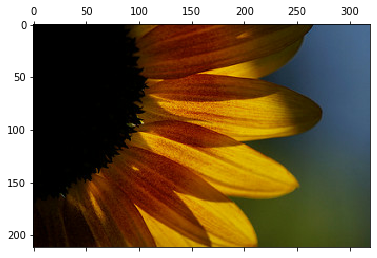


Tulip 2


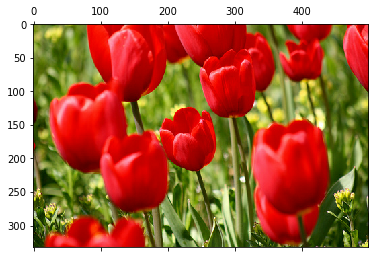


Sunflower 3


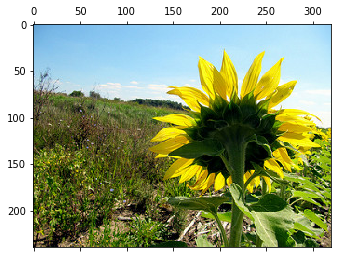


Daisy 1


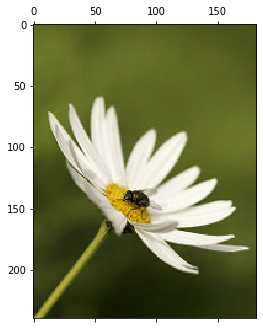


Tulip 2


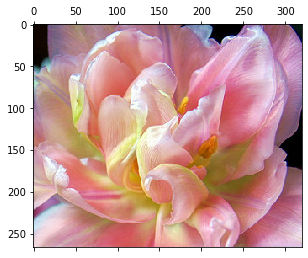


Sunflower 3


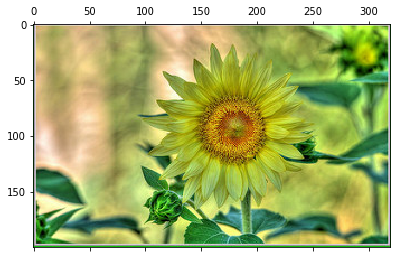


Sunflower 3


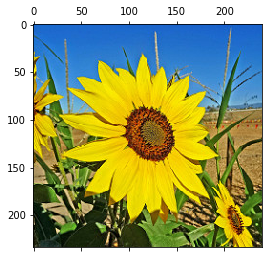


Sunflower 3


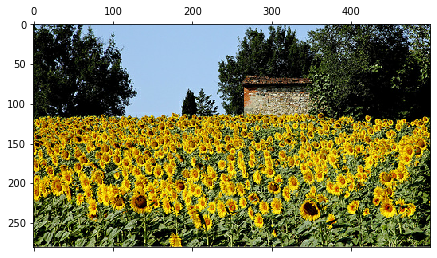


Dandelion 0


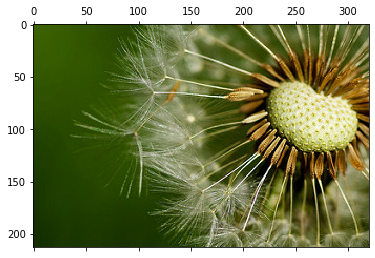


Sunflower 3


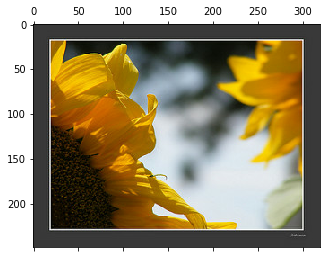

In [8]:
for img, label in ds.take(10): # Taking a look at the data.
  print(LABELS[label.numpy()], label.numpy())
  plt.matshow(img.numpy())
  plt.show()
  print()

In [9]:
def preprocess_training_data(img, label):
  """
  This function preprocesses `img`.
  :param img: The image.
  param label: The label of the image.
  :return: tuple, The preprocessed image and the label.
  """
  
  img = tf.image.resize(img, [HEIGHT, WIDTH])

  img = tf.cast(img, tf.float32)
  img = tf.image.random_flip_up_down(img, seed=0)
  img = tf.image.random_flip_left_right(img, seed=0)
  img = tf.image.random_brightness(img, max_delta=0.95)
  img = tf.image.random_contrast(img, lower=0.25, upper=0.95)
  img /= 255.

  label = tf.cast(label, dtype="uint8")

  return img, label

def preprocess_testing_data(img, label):
  """
  This function preprocesses `img`.
  :param img: The image.
  param label: The label of the image.
  :return: tuple, The preprocessed image and the label.
  """
  img = tf.image.resize(img, [HEIGHT, WIDTH])
  img = tf.cast(img, tf.float32)
  img /= 255.

  label = tf.cast(label, dtype="uint8")

  return img, label

Splitting the data into training, validation and testing datasets.

In [10]:
ds_train = ds.take(TRAIN_SIZE) # Taking the training data.
ds_test_val = ds.skip(TRAIN_SIZE)
ds_val = ds_test_val.take(VAL_SIZE) # Taking the validation data.
ds_test = ds_test_val.skip(VAL_SIZE) # Taking the testing data.

Preparing the training data:

In [11]:
ds_train = ds_train.map(preprocess_testing_data) # Preparing the images.

tf.Tensor(3, shape=(), dtype=uint8)


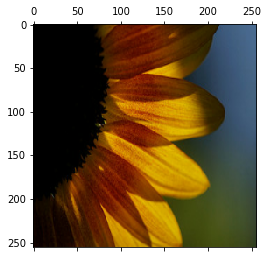

tf.Tensor(2, shape=(), dtype=uint8)


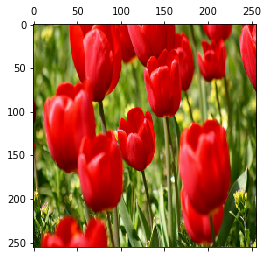

tf.Tensor(3, shape=(), dtype=uint8)


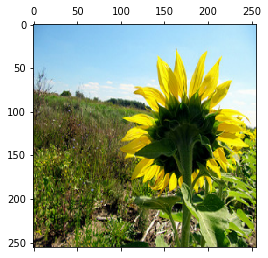

tf.Tensor(4, shape=(), dtype=uint8)


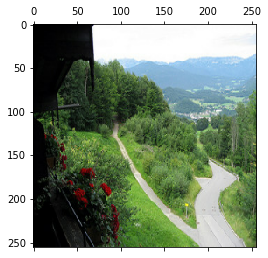

tf.Tensor(3, shape=(), dtype=uint8)


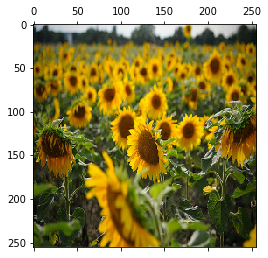

tf.Tensor(0, shape=(), dtype=uint8)


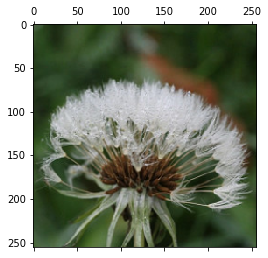

tf.Tensor(0, shape=(), dtype=uint8)


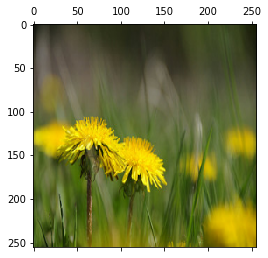

tf.Tensor(0, shape=(), dtype=uint8)


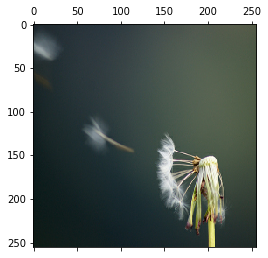

tf.Tensor(0, shape=(), dtype=uint8)


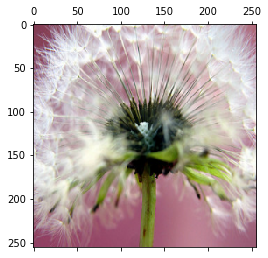

tf.Tensor(1, shape=(), dtype=uint8)


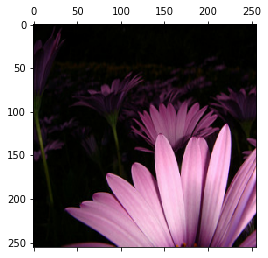

In [12]:
for img, label in ds_train.take(10): # Taking a look at the data.
  print(label)
  plt.matshow(img.numpy())
  plt.show()

In [13]:
ds_train = ds_train.cache().shuffle(TRAIN_SIZE).batch(BATCH_SIZE).prefetch(1) # Now the dataset is ready.

Preparing the validation data:

In [14]:
ds_val = ds_val.map(preprocess_testing_data) # Preparing the images.

tf.Tensor(2, shape=(), dtype=uint8)


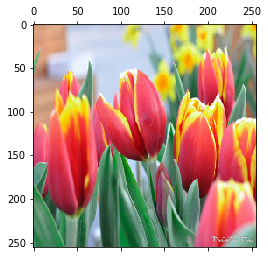

tf.Tensor(0, shape=(), dtype=uint8)


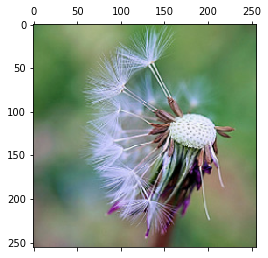

tf.Tensor(4, shape=(), dtype=uint8)


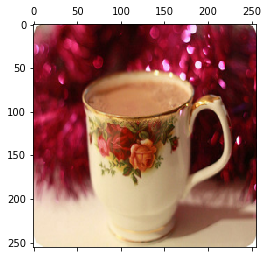

tf.Tensor(2, shape=(), dtype=uint8)


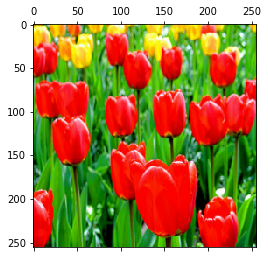

tf.Tensor(4, shape=(), dtype=uint8)


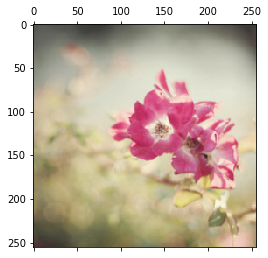

tf.Tensor(0, shape=(), dtype=uint8)


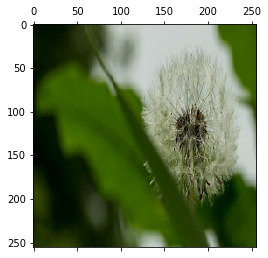

tf.Tensor(2, shape=(), dtype=uint8)


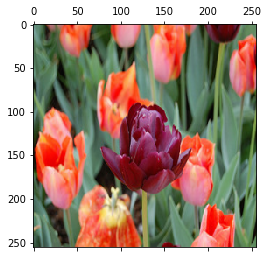

tf.Tensor(2, shape=(), dtype=uint8)


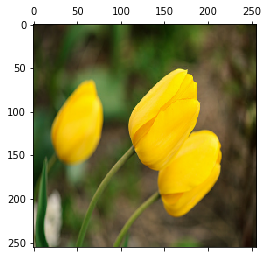

tf.Tensor(1, shape=(), dtype=uint8)


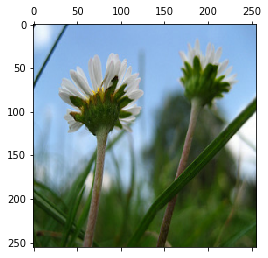

tf.Tensor(1, shape=(), dtype=uint8)


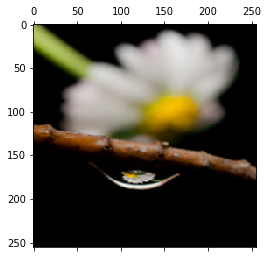

In [15]:
for img, label in ds_val.take(10): # Taking a look at the data.
  print(label)
  plt.matshow(img.numpy())
  plt.show()

In [16]:
ds_val = ds_val.shuffle(VAL_SIZE).batch(BATCH_SIZE).prefetch(1) # Now the dataset is ready.

Preparing the testing data:

In [17]:
ds_test = ds_test.map(preprocess_testing_data) # Preparing the images.

tf.Tensor(4, shape=(), dtype=uint8)


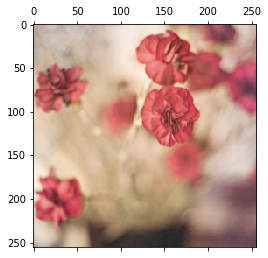

tf.Tensor(1, shape=(), dtype=uint8)


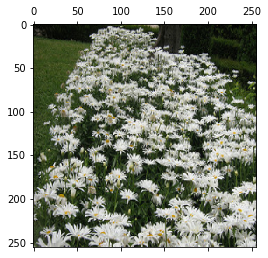

tf.Tensor(4, shape=(), dtype=uint8)


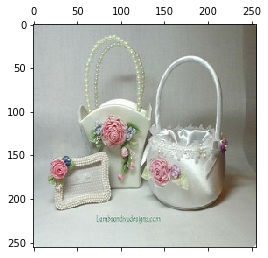

tf.Tensor(0, shape=(), dtype=uint8)


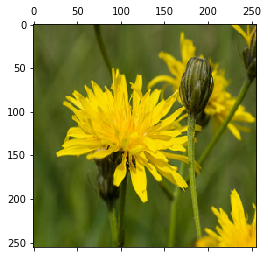

tf.Tensor(4, shape=(), dtype=uint8)


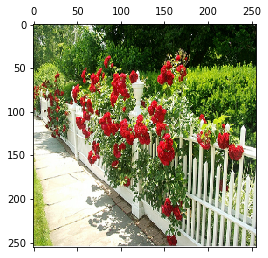

tf.Tensor(0, shape=(), dtype=uint8)


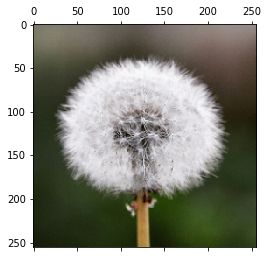

tf.Tensor(0, shape=(), dtype=uint8)


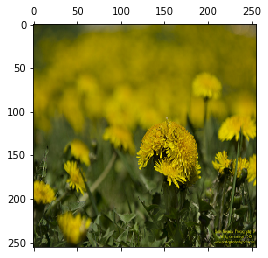

tf.Tensor(1, shape=(), dtype=uint8)


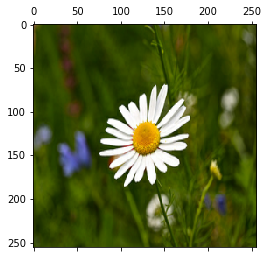

tf.Tensor(2, shape=(), dtype=uint8)


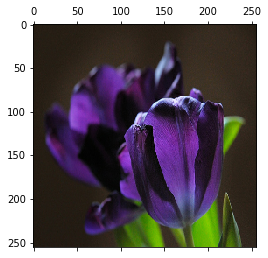

tf.Tensor(1, shape=(), dtype=uint8)


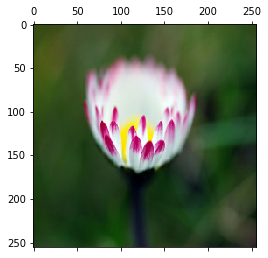

In [18]:
for img, label in ds_test.take(10): # Taking a look at the data.
  print(label)
  plt.matshow(img.numpy())
  plt.show()

In [19]:
ds_test = ds_test.shuffle(len(ds_test)).batch(BATCH_SIZE).prefetch(1) # Now the dataset is ready.

# Building the Model

In [20]:
class CNNBlock(Layer):
  """
  This class represents a custom CNN Block with two layers: the first layer is `Conv2D`,
    and the second layer is `BatchNormalization`.
  :param filters: the number of filters in the `Conv2D` layer.
  :param kernel_size: tuple, the kernel size for the `Conv2D` layer.
  """

  def __init__(self, filters, kernel_size):
    super(CNNBlock, self).__init__()

    self.conv_layer = Conv2D(filters, kernel_size, padding="same")
    self.batch_norm = BatchNormalization()
    self.relu = ReLU()

  def call(self, input_tensor, training=False):
    """
    Calling this layer.
    :param input_tensor: A tensor with the data.
    :param training: bool, `True` if this layer is being trained, `False` otherwise.
      Default to `False`.
    :return: A processed tensor.
    """
    x = self.conv_layer(input_tensor)
    x = self.batch_norm(x, training=training)
    x = self.relu(x)

    return x

In [21]:
class ResNetLayer(Layer):
  """
  This class represents a simple ResNet block.
  :param filters: A list of three integers. 
    Each element in the list is the number of filters for the CNNBlock.
  :param kernel_sizes: A list with three tuples.
    Each element in the list is the kernel size for the CNNBlock.
  """

  def __init__(self, filters, kernel_sizes):
    super(ResNetLayer, self).__init__()
    
    assert len(filters) == 3
    assert len(kernel_sizes) == 3

    self.cnn_block1 = CNNBlock(filters[0], kernel_sizes[0])
    self.cnn_block2 = CNNBlock(filters[1], kernel_sizes[1])
    self.cnn_block3 = CNNBlock(filters[2], kernel_sizes[2])
    self.max_pooling = MaxPooling2D()
    self.identity_mapping = Conv2D(filters[1], 3, padding="same")
    self.num_layers = 5

  def call(self, input_tensor, training=False):
    """
    Calling this layer.
    :param input_tensor: A tensor with the data.
    :param training: bool, `True` if this layer is being trained, `False` otherwise.
      Default to `False`.
    :return: A processed tensor.
    """

    x = self.cnn_block1(input_tensor, training=training)
    x = self.cnn_block2(x, training=training)
    x = self.cnn_block3(x + self.identity_mapping(input_tensor), training=training)
    x = self.max_pooling(x)

    return x

  def get_config(self):
    config = super().get_config().copy()
    config.update({
        "num_layers": self.num_layers,
    })

    return config

In [22]:
class ResNet(keras.Model):
  """
  This is a custom ResNet model.
  :param num_classes: int, the number of classes.
  """
  def __init__(self, num_classes=5):
    super(ResNet, self).__init__()

    self.resnet_layer1 = ResNetLayer(filters=[32, 32, 64], kernel_sizes=[(3, 3), (3, 3), (3, 3)])
    self.resnet_layer2 = ResNetLayer(filters=[92, 128, 92], kernel_sizes=[(3, 3), (3, 3), (3, 3)])
    self.resnet_layer3 = ResNetLayer(filters=[64, 32, 32], kernel_sizes=[(3, 3), (3, 3), (3, 3)])
    self.batch_norm = BatchNormalization()
    self.global_max_pooling = GlobalMaxPooling2D()
    self.flatten = Flatten()
    self.leaky_relu = LeakyReLU()
    self.dense = Dense(128, activation="relu")
    self.dropout = Dropout(0.4)
    self.output_layer = Dense(num_classes, activation="softmax")

    self.num_layers = 10

  def call(self, input_tensor, training=False):
    x = self.resnet_layer1(input_tensor, training=training)
    x = self.resnet_layer2(x, training=training)
    x = self.resnet_layer3(x, training=training)
    x = self.batch_norm(x, training=training)
    x = self.global_max_pooling(x)
    x = self.flatten(x)
    x = self.leaky_relu(x)
    x = self.dense(x)
    x = self.dropout(x)
    x = self.output_layer(x)

    return x

  def build_model(self):
    """
    This function creates an instance of this ResNet model.
    :return: `keras.Model`, an instance of this ResNet model.
    """
    inputs = keras.Input(shape=(HEIGHT, WIDTH, 3))
    output = self.call(inputs)
    return keras.Model(inputs=inputs, outputs=output)

  def get_config(self):
    config = super().get_config.copy()
    config.update({
        "num_layers" : self.num_layers,
        "num_classes" : self.num_classes
    })

In [23]:
model = ResNet().build_model()

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
res_net_layer (ResNetLayer)  (None, 128, 128, 64)      30048     
_________________________________________________________________
res_net_layer_1 (ResNetLayer (None, 64, 64, 92)        340376    
_________________________________________________________________
res_net_layer_2 (ResNetLayer (None, 32, 32, 32)        107808    
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
global_max_pooling2d (Global (None, 32)                0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0     

In [25]:
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [26]:
model.fit(ds_train, batch_size=BATCH_SIZE, epochs=15, validation_data=ds_val)

Epoch 1/15
81/81 [==============================] - 90s 595ms/step - loss: 1.5103 - accuracy: 0.3149 - val_loss: 1.2931 - val_accuracy: 0.4496
Epoch 2/15
81/81 [==============================] - 45s 556ms/step - loss: 1.2568 - accuracy: 0.4729 - val_loss: 1.1886 - val_accuracy: 0.5477
Epoch 3/15
81/81 [==============================] - 45s 562ms/step - loss: 1.1200 - accuracy: 0.5274 - val_loss: 0.9950 - val_accuracy: 0.5995
Epoch 4/15
81/81 [==============================] - 46s 570ms/step - loss: 0.9876 - accuracy: 0.6154 - val_loss: 0.9953 - val_accuracy: 0.6022
Epoch 5/15
81/81 [==============================] - 45s 562ms/step - loss: 0.9207 - accuracy: 0.6450 - val_loss: 0.9641 - val_accuracy: 0.6294
Epoch 6/15
81/81 [==============================] - 45s 561ms/step - loss: 0.8841 - accuracy: 0.6497 - val_loss: 0.8542 - val_accuracy: 0.6431
Epoch 7/15
81/81 [==============================] - 46s 572ms/step - loss: 0.8077 - accuracy: 0.6831 - val_loss: 0.7843 - val_accuracy: 0.6812

In [27]:
model.save("flower_recognition_model")

INFO:tensorflow:Assets written to: flower_recognition_model/assets


INFO:tensorflow:Assets written to: flower_recognition_model/assets


# Evaluating the model




In [28]:
model.evaluate(ds_test)

23/23 [==============================] - 10s 263ms/step - loss: 0.7283 - accuracy: 0.7371


[0.7282594442367554, 0.7370572090148926]